<a href="https://colab.research.google.com/github/Rajitha-SL/My-AI-Projects/blob/AI-and-ML-learning/cifar10_cnn_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='https://github.com/Rajitha-SL/My-AI-Projects/blob/AI-and-ML-learning/notebook_ims/cifar_data.png?raw=1' width=70% height=70% />

In [1]:
from google.colab import files
files.upload()

Saving requirements.txt to requirements.txt
Saving helpers.py to helpers.py


{'requirements.txt': b'opencv-python-headless==4.5.3.56\nmatplotlib==3.4.3\nnumpy==1.21.2\npillow==7.0.0\nbokeh==2.1.1\ntorch==1.11.0\ntorchvision==0.12.0\ntqdm==4.63.0\nipywidgets==7.6.5\nlivelossplot==0.5.4\npytest==7.1.1\npandas==1.3.5\nseaborn==0.11.2\n',
 'helpers.py': b'import matplotlib.pyplot as plt\nimport numpy as np\nimport pandas as pd\nimport seaborn as sns\nimport torch\nfrom livelossplot import PlotLosses\nfrom livelossplot.outputs import MatplotlibPlot\nfrom torch.utils.data.sampler import SubsetRandomSampler\nfrom torchvision import datasets\nfrom tqdm import tqdm\n\n\ndef get_train_val_data_loaders(batch_size, valid_size, transforms, num_workers):\n\n    # Get the CIFAR10 training dataset from torchvision.datasets and set the transforms\n    # We will split this further into train and validation in this function\n    train_data = datasets.CIFAR10("data", train=True, download=True, transform=transforms)\n\n    # Compute how many items we will reserve for the validation

In [2]:
!pip install -q -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 9.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [3]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [4]:
!pip install livelossplot
import torchvision.transforms
import multiprocessing
from helpers import get_train_val_data_loaders, get_test_data_loader

# number of subprocesses to use for data loading
num_workers = multiprocessing.cpu_count()
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transforms = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# If you want to refresh how to load and split data in pytorch, open the helpers.py file
# and read the code. We have documented it with comments so you can follow along easily
train_dl, valid_dl = get_train_val_data_loaders(batch_size, valid_size, transforms, num_workers)
test_dl = get_test_data_loader(batch_size, transforms, num_workers)

# For convenience let's group them together in a dictionary
data_loaders = {
    'train': train_dl,
    'valid': valid_dl,
    'test': test_dl
}

100%|██████████| 170498071/170498071 [00:12<00:00, 13489645.35it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [5]:
# specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

### Visualize a Batch of Training Data

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img, sub):
    img = img / 2 + 0.5  # unnormalize
    sub.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    sub.axis("off")

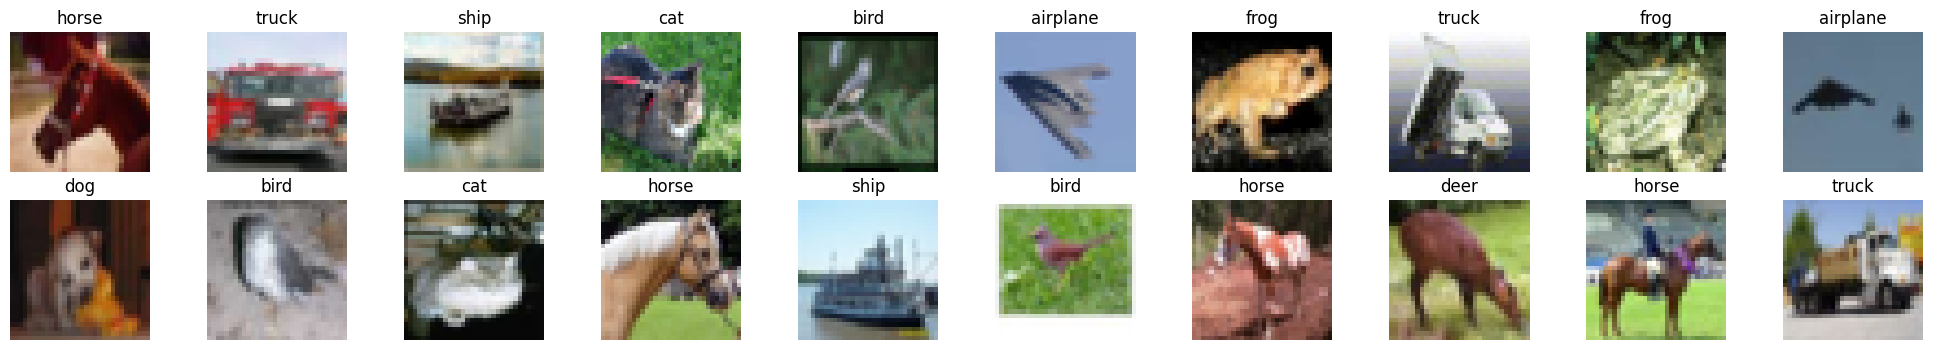

In [20]:
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
# display 20 images
# NOTE: make sure your batch size is at least 20
fig, subs = plt.subplots(2, 10, figsize=(25, 4))
for i, sub in enumerate(subs.flatten()):
    imshow(images[i], sub)
    sub.set_title(classes[labels[i]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

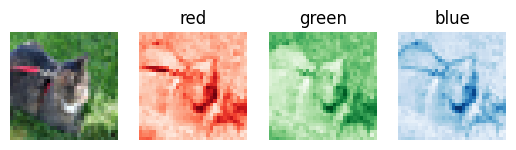

In [21]:
rgb_img = np.squeeze(images[3])
channels = ['composite', 'red', 'green', 'blue']
cmaps = [None, 'Reds', 'Greens', 'Blues']

fig, subs = plt.subplots(1, 4)

for i, sub in enumerate(subs.flatten()):

    if i == 0:
        imshow(rgb_img, sub)
    else:
        img = rgb_img[i-1]
        sub.imshow(img, cmap=cmaps[i])
        sub.set_title(channels[i])
        sub.axis("off")

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

A network with 2 convolutional layers is shown in the image below and in the code, and you've been given starter code with one convolutional and one maxpooling layer.

<img src='https://github.com/Rajitha-SL/My-AI-Projects/blob/AI-and-ML-learning/notebook_ims/2_layer_conv.png?raw=1' height=50% width=50% />

#### TODO: Define a model with multiple convolutional layers, and define the feedforward metwork behavior.

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting.

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) to help decide on a final structure.

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`.

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [27]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self, n_classes=10):

      super(Net, self).__init__()

      # YOUR CODE HERE
      # Convolutional layer 1. It sees 3x32x32 image tensor
      # and produce 16 feature maps 32x32 (i.e. a tensor 16x32x32)
      self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1)
      self.relu1 = nn.ReLU()
      self.pool1 = nn.MaxPool2d(2, 2)
      # 2x2 pooling with stride 2. It sees tensors 16x32x32
      # and halves their size. (i.e. the out put will be 16x16x16)

      # Convolutional layer 2. (sees the output of the previous layer, i.e.
      # 16x16x16 tensor)
      self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
      self.relu2 = nn.ReLU()
      self.pool2 = nn.MaxPool2d(2, 2) # 32x8x8

      # Convolutional layer 3. (sees the output of the previous layer, i.e.
      # 32x8x8 tensor)
      self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
      self.relu3 = nn.ReLU()
      self.pool3 = nn.MaxPool2d(2, 2) # 64x4x4

      # Linear layer (64 * 4 * 4 -> 500)
      self.flatten = nn.Flatten()
      self.fc1 = nn.Linear(64 * 4 * 4, 500)
      self.dp1 = nn.Dropout(0.5)
      self.rl1 = nn.ReLU()

      self.fc2 = nn.Linear(120, 84)
      self.dp2 = nn.Dropout(0.5)
      self.rl2 = nn.ReLU()

      self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):

      # YOUR CODE HERE
      x = self.pool1(self.relu1(self.conv1(x)))
      x = self.pool2(self.relu2(self.conv2(x)))
      x = self.pool3(self.relu3(self.conv3(x)))

      x = self.flatten(x)

      x = self.rl1(self.dp1(self.fc1(x)))
      x = self.rl2(self.dp2(self.fc2(x)))
      x = self.fc3(x)

      return x


# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dp1): Dropout(p=0.5, inplace=False)
  (rl1): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (dp2): Dropout(p=0.5, inplace=False)
  (rl2): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [40]:
# We can also use nn.Sequential, which makes things a lot easier
class Net(nn.Module):
  def __init__(self, n_classes=10):
    super(Net, self).__init__()
    self.model = nn.Sequential(
        nn.Conv2d(in_channels =3, out_channels = 16, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(in_channels =16, out_channels = 32, kernel_size = 3, padding = 1), # 32x16x16
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(in_channels =32, out_channels = 64, kernel_size = 3, padding = 1), # 64x8x8
        nn.ReLU(),
        nn.MaxPool2d(2,2),  # 64x4x4
        nn.Flatten(),       # 1x64x4x4
        nn.Linear(64 * 4 * 4, 500),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(500, 84),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(84, n_classes)
    )

  def forward(self, x):
    return self.model(x)

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=500, bias=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): ReLU()
    (13): Linear(in_features=500, out_features=84, bias=True)
    (14): Dropout(p=0.5, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=84, out_features=10, bias=True)
  )
)


## How many parameters?

Now that you built the network, can you compute with pen and paper how many parameters does your network have? Does your answer match the output of the following cell?

In [41]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

579018

## Visualize your network (optional)

You can visualize your achitecture by using netron.app. Just execute the following cell (which will save the network to a file called "cifar10_network.pt" in this directory), then download the produced `cifar10_network.pt` to your computer. Finally, go to [Netron.app](https://netron.app) and click on `Open Model`, and select the file you just downloaded.

In [42]:
scripted = torch.jit.script(model)
torch.jit.save(scripted, "cifar10_network.pt")

In [43]:
!ls

cifar10_network.pt  helpers.py	 requirements.txt
data		    __pycache__  sample_data


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py). Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

#### TODO: Define the loss and optimizer and see how these choices change the loss over time.

In [44]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
loss = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.01)

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting. (In fact, in the below example, we could have stopped around epoch 33 or so!)

In [45]:
from helpers import optimize

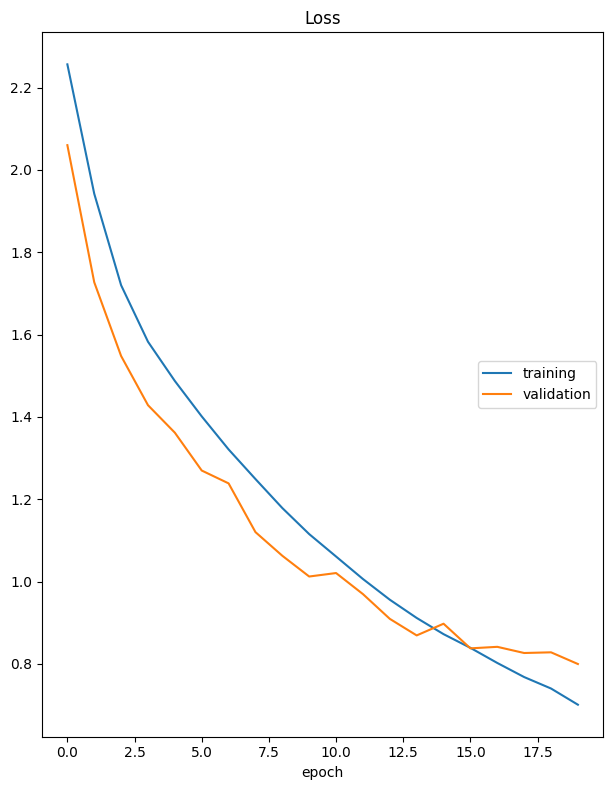

Loss
	training         	 (min:    0.701, max:    2.256, cur:    0.701)
	validation       	 (min:    0.800, max:    2.060, cur:    0.800)


In [46]:
optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    20,
    "cifar10_best_valid.pt",
    interactive_tracking=True
)

###  Load the Model with the Lowest Validation Loss

In [47]:
model.load_state_dict(torch.load('cifar10_best_valid.pt'))

<All keys matched successfully>

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [48]:
from helpers import one_epoch_test

In [49]:
test_loss, preds, actuals = one_epoch_test(data_loaders['valid'], model, loss)

Testing: 100%|████████████████████████████████| 500/500 [00:13<00:00, 36.66it/s]

Test Loss: 0.799660


Test Accuracy: 72% (7286/10000)


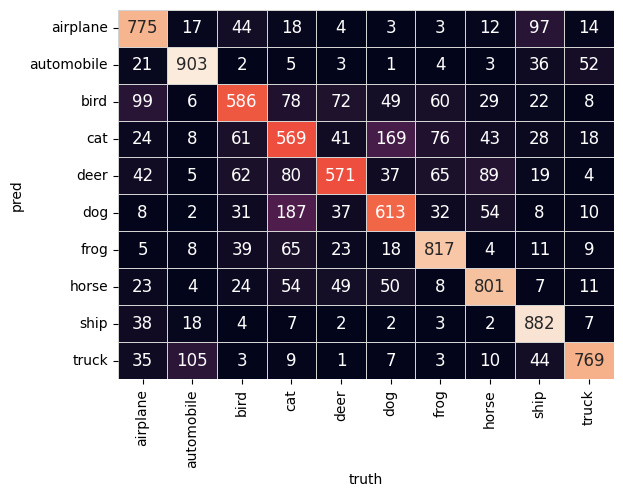

In [50]:
from helpers import plot_confusion_matrix

cm = plot_confusion_matrix(preds, actuals, classes)

In [51]:
print("Accuracy by class:\n")
for i, col in enumerate(cm):
    print(f"    {col:11s}: {cm[col][i] / cm[col].sum():.2f}")

Accuracy by class:

    airplane   : 0.72
    automobile : 0.84
    bird       : 0.68
    cat        : 0.53
    deer       : 0.71
    dog        : 0.65
    frog       : 0.76
    horse      : 0.77
    ship       : 0.76
    truck      : 0.85


### Question: What are your model's weaknesses and how might they be improved?

** Answer**: When the object is a dog, a cat or a bird the model prediction is less accuate. But if it is an automobile, a truck the efficiency is high.

_NOTE_: we will see how to improve the performances even further with simple things like data augmentation and batch norm

### Visualize Sample Test Results

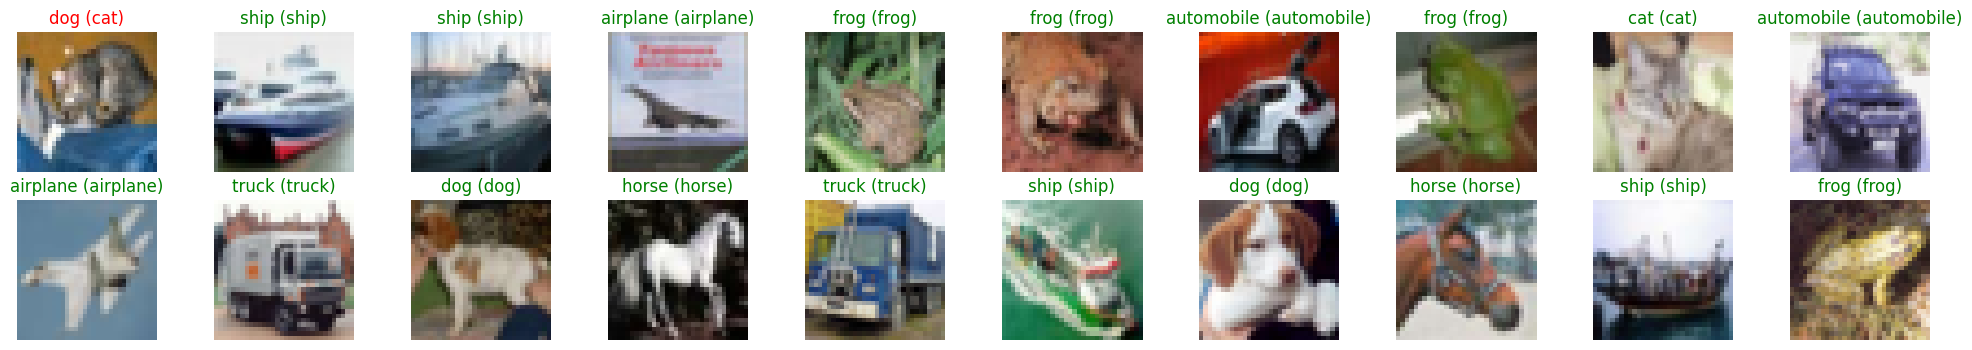

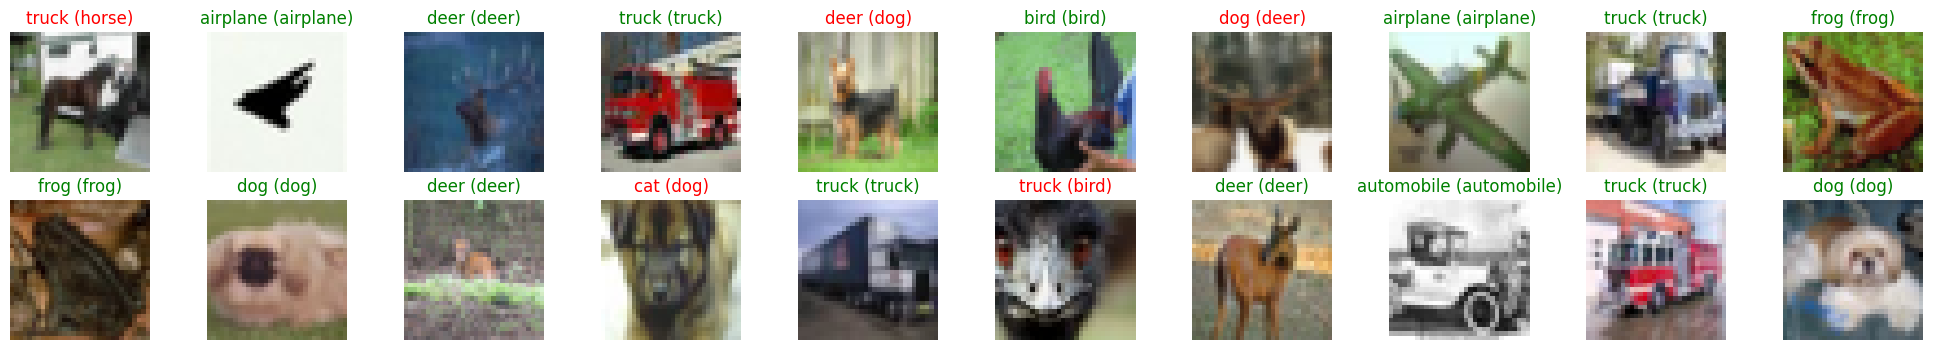

In [53]:
# obtain one batch of test images
dataiter = iter(data_loaders['test'])

for i in range(2):
    images, labels = next(dataiter)
    images.numpy()

    # move model inputs to cuda, if GPU available
    if train_on_gpu:
        images = images.cuda()

    # get sample outputs
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

    # plot the images in the batch, along with predicted and true labels
    fig, subs = plt.subplots(2, 10, figsize=(25, 4))
    for i, ax in enumerate(subs.flatten()):
        imshow(images[i].cpu().numpy(), ax)
        ax.set_title("{} ({})".format(classes[preds[i]], classes[labels[i]]),
                     color=("green" if preds[i]==labels[i].item() else "red"))
        ax.axis("off")